In [7]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
#%pip install ipykernel --user
#%pip install stable_baselines3 --user
#%pip install tensorboard --user
#%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


# STABLEBASELINES TESTBED

In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools
import math

from datetime import datetime

from scipy.special import softmax

# INCLUDE CHARGI DISCHARGE CODE IN OBS SPACE


import sys
sys.path.append("../../cell_simulation")

import sys
sys.path.append("../../cell_simulation")

import SimCellPack as scp


np.set_printoptions(precision=7)

#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):


# normalize actions to = nr cells, or have 1 buffer cell that takes the rest of the usage
class BatteryEnv(gym.Env):

   def __init__(self, cellModel, numCells, simCycles, seed, profile, balancing, getSOCsWhen, sampleFactor, utilization, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.6"
      self.num_envs = 1

      self.numCells = numCells

      # Define cell model simualtor 
      self.cellModel = scp.SimCellPack(cellModel = cellModel, numCells = numCells, simCycles = simCycles, seed = seed, profile=profile,
                                        balancing = balancing, getSOCsWhen=getSOCsWhen, sampleFactor = sampleFactor, utilization=utilization)
      self.cellModel.startSim()

   
      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.numCells,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.numCells,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None

      self.stop_rewards = False
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."

      self.episode_time += 1

      # Scale the action space between 0 and 1
      battery_current_values = get_converted_action(action, False)


      # stop any distcharge on the smallest SOC
      initial_min_soc = min(self.state)
      index_initial_min_soc = self.state.index(initial_min_soc)
      # battery_current_values[index_initial_min_soc] = 0.0
      # action[index_initial_min_soc] = -1.0

      nr_cells_already_balanced = 0
      for soc_index in range(0, len(self.state)):
         if soc_index != index_initial_min_soc: 
            diff = self.state[soc_index] - initial_min_soc
            if diff < 0.005:
            # if math.isclose(self.state[soc_index], initial_min_soc, abs_tol=0.005):
               nr_cells_already_balanced = nr_cells_already_balanced + 1 

      # Helper function: stop from dischaging          
      # if nr_cells_already_balanced == (len(self.state) -1 ):
      #    for i in range(0, len(self.state)):
      #       battery_current_values[i] = 1.0
      #       action[i] = 0.0

      # print("Sim feedback: " + str(battery_current_values))

      # Send the action as feedback to the cell model
      self.cellModel.sendSimFeedback(battery_current_values)

      # Flags for determining certain occurences
      terminated = False
      truncated = False

      # Save state before action
      initial_state = self.state

      #Apply action to state
      code, self.state = self.cellModel.getSimStep()

      #print("Step: state: " + str(self.state) + " code: " + str(code))

      # Cell simulation finished, terminate
      if code == 0.0:
         truncated = True
      elif code != 1:
         # if not DISCHATGING, apply no action
         for i in range(0, len(self.state)):
            battery_current_values[i] = 1.0
            action[i] = 0.0

      # hilre code ,save states, send to info
      

      # Compute reward and termination cases
      # Apply step reward. Continue running.
      
      reward = 0
      # if (self.episode_time > 1200):
      reward, terminated = compute_ballancing_reward(self.state, initial_state, battery_current_values, False)

      # if(self.stop_rewards == True):
      #    reward = 0

      # if ((truncated == True or terminated == True) and self.episode_time < 1000):
      #    reward -= self.episode_time - 1000


      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}

   def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None,):
   # Reset runs first before starting the simulation to get the initial states
        
      super().reset(seed=seed)

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("!-- RESTARTED AT : ", current_time)

      # Stops and restarts the cell simulation
      self.cellModel.resetSim()

      now = datetime.now()
      current_time = now.strftime("%H:%M:%S")
      print("DONE RESTARTING: ", current_time)


      self.episode_time = 0
      self.stop_rewards = False

      # Get initial states from the cell model
      code, self.state = self.cellModel.getSimStep()

      #print("Reset state: " + str(self.state))

      return np.array(self.state, dtype=np.float32), {}
   
   def stop_sim(self):
      self.cellModel.stopSim()

   def __del__(self):
      self.cellModel.stopSim()



#CONVERT ACTION
   
def get_converted_action(action, should_print = True):

   if should_print:
      print("INITIAL VALUES:  " + str(action))


   if (type(action) != np.ndarray):
      action = np.array(action)



   current_values = []
   for current in action:
      shifted_value = ((current + 1.0))/2.0 + 0.5 #from [-1, 1] to [0.5, 1.5], to be reduced from SoC
      current_values.append(shifted_value)
   
   current_values = current_values/sum(current_values) # Softmax normalization
   current_values = current_values * len(current_values) # Scale to number of cells/values in array

   if should_print:
      print("SHIFTED VALUES:  " + str(current_values))


   # normalized_values = []
   # for current in current_values:
   #    normalized_value = (current/float(np.sum(current_values))) * action.size
   #    normalized_values.append(normalized_value)
      
   minPower = 0.5
   maxPower = 1.5

   a = current_values
   
   if a.min() < minPower:
      min_indexes = []
      diff = 0.0
      a_sum = 0.0
      for i in range(len(a)):
         if a[i] < minPower:
               min_indexes.append(i)
               diff = diff + minPower-a[i]
         else:
               a_sum = a_sum + a[i]
      a = a - (a/a_sum)*diff
      for i in min_indexes: a[i] = minPower 

   if a.max() > maxPower:
      max_indexes = []
      diff = 0.0
      a_sum = 0.0
      for i in range(len(a)):
         if a[i] > maxPower:
               max_indexes.append(i)
               diff = diff + a[i]-maxPower
         else:
               a_sum = a_sum + a[i]
      a = a + (a/a_sum)*diff
      for i in max_indexes: a[i] = maxPower 

   if should_print:
      print("NRMLIZD VALUES:  " + np.array2string(a))


   return np.array(a)


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff), or (mean_diff*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.02, 0.05, 0, 0.01, 0.1]
numbers = [0.8268956, 0.7947008, 0.8274856]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation

# Get reward for a given step
def compute_ballancing_reward(initial_socs, action_socs, action, should_print):



   reward = 0

   initial_min_soc = min(initial_socs)
   action_min_soc = min(action_socs)

   index_initial_min_soc = initial_socs.index(min(initial_socs))
   index_action_min_soc = action_socs.index(min(action_socs))

   if (should_print):
      print("INITIAL MIN SOC :  " + str(initial_min_soc) + "      ACTION  MIN SOC :  " + str(action_min_soc))
      print("INDEX INITIAL MIN SOC :  " + str(index_initial_min_soc) + "      INDEX ACTION  MIN SOC :  " + str(index_action_min_soc))


   terminated = False

   nr_cells_balanced_before_action = 0
   init_diff_sum = 0
   for soc_index in range(0, len(action_socs)):
      if soc_index != index_initial_min_soc: 
         init_diff = initial_socs[soc_index] - initial_min_soc
         init_diff_sum += init_diff
         if init_diff < 0.005 and init_diff > 0:
            nr_cells_balanced_before_action = nr_cells_balanced_before_action + 1
   
   # count nr of cells within 0.005 of the min soc
         

   # check how many SOCs were balanced after action (state + action)
   nr_cells_balanced_after_action = 0
   act_diff_sum = 0
   for soc_index in range(0, len(action_socs)):
      if soc_index != index_initial_min_soc: 
         # if math.isclose(action_socs[soc_index], action_min_soc, abs_tol=0.001):
         diff = action_socs[soc_index] - action_min_soc
         act_diff_sum += diff
         if diff < 0.005 and diff > 0:
            nr_cells_balanced_after_action = nr_cells_balanced_after_action + 1
         
         # reward -= diff
   
   # reward = reward/len(action_socs)
            
   reward = 0


   # if all SOCs are balanced after action, reward
   # if there are nr_cells - 1 of cells within 0.0005 of min_soc before action AND after action 
   if nr_cells_balanced_after_action == (len(action_socs) -1) and nr_cells_balanced_before_action == (len(action_socs) -1):
      reward = 1
   elif nr_cells_balanced_after_action == (len(action_socs) -1) :
      reward = 0.5
   else:
      if act_diff_sum < init_diff_sum :
         reward += 0.1
      elif act_diff_sum > init_diff_sum :
         reward -= 0.1
   

   
   # else:
   #    reward = -np.std(action_socs, dtype=np.float32)*10

      
   # else:
   #    reward = 0.01-np.std(action_socs, dtype=np.float32)

   # maxPenaltyPerAction = 1/len(action)
   
   # for current in action:
   #    reward -= maxPenaltyPerAction*current




   return reward, terminated






print("-----------")
# print("REWARD: " + str(compute_ballancing_reward([0.3801861, 0.33264282, 0.34823087], [0.3801861, 0.33264282, 0.34823087 ], [0.0, 0., 0.0], True)))
# print("REWARD: " + str(compute_ballancing_reward([0.7555555, 0.7155555, 0.7555555], [0.725555, 0.7155555, 0.755555 ], [0.0, 0., 0.0], True)))
# print("REWARD: " + str(compute_ballancing_reward([0.725555, 0.7155555, 0.7555555], [0.721555, 0.7115555, 0.755555 ], [0.0, 0., 0.0], True)))

# print("REWARD: " + str(compute_ballancing_reward([0.725555, 0.7155555, 0.7555555], [0.721555, 0.7115555, 0.735555 ], [0.0, 0., 0.0], True)))
# print("REWARD: " + str(compute_ballancing_reward([0.18204315, 0.17318097, 0.17277935], [0.18178657, 0.17259763, 0.17277274], [0.0, 0., 0.0], True)))


# print("REWARD: " + str(compute_ballancing_reward([0.7555555, 0.7544555, 0.7555555], [0.7555555, 0.7548555, 0.7555555], [0.15639728, 0.,         1.        ], True)))
# print("REWARD: " + str(compute_ballancing_reward([0.7555555, 0.7544555, 0.7555555], [0.7555555, 0.7548555, 0.7555555], [0.15639728, 0.,         1.        ], True)))

numbers = np.array([-1, 1, 1], dtype="float32")
print(get_converted_action(numbers))

numbers = np.array([-1, -1, 1], dtype="float32")
print(get_converted_action(numbers))

numbers = np.array([1, 1, 1], dtype="float32")
print(get_converted_action(numbers))

numbers = np.array([-1., 0., 0.], dtype="float32")
print(get_converted_action(numbers))

numbers = np.array((0.6939725664077502, 0.6997109733538531, 0.6881170848524525), dtype="float32")
print(get_converted_action(numbers))

numbers = np.array((0.6239725664077502, 0.6997109733538531, 0.6881170848524525), dtype="float32")
print(get_converted_action(numbers))

# action distribution: the action-reward pair that happens the most will shape the policy the most
# breadcrumb mentality: one reward should lead to another, the agent should be able to quickly get to the biggest reward
# negative rewards: if it gets punidhed per step, it will try to find the quickest way to stop stepping and kill itself.

0.03278480000000006
0.0153177325
-----------
INITIAL VALUES:  [-1.  1.  1.]
SHIFTED VALUES:  [0.4285714 1.2857143 1.2857143]
NRMLIZD VALUES:  [0.5  1.25 1.25]
[0.5  1.25 1.25]
INITIAL VALUES:  [-1. -1.  1.]
SHIFTED VALUES:  [0.6 0.6 1.8]
NRMLIZD VALUES:  [0.75 0.75 1.5 ]
[0.75 0.75 1.5 ]
INITIAL VALUES:  [1. 1. 1.]
SHIFTED VALUES:  [1. 1. 1.]
NRMLIZD VALUES:  [1. 1. 1.]
[1. 1. 1.]
INITIAL VALUES:  [-1.  0.  0.]
SHIFTED VALUES:  [0.6 1.2 1.2]
NRMLIZD VALUES:  [0.6 1.2 1.2]
[0.6 1.2 1.2]
INITIAL VALUES:  [0.6939726 0.699711  0.6881171]
SHIFTED VALUES:  [1.0000145 1.0021446 0.9978409]
NRMLIZD VALUES:  [1.0000145 1.0021446 0.9978409]
[1.0000145 1.0021446 0.9978409]
INITIAL VALUES:  [0.6239726 0.699711  0.6881171]
SHIFTED VALUES:  [0.9825404 1.0109005 1.0065592]
NRMLIZD VALUES:  [0.9825404 1.0109005 1.0065592]
[0.9825404 1.0109005 1.0065592]


# PLOTTING FUNCTIONS:

In [2]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=1)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())

# plot_results(log_dir)


In [3]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [4]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize


# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(cellModel="P14", numCells = 3, simCycles = 10, seed=1, profile = "us06", 
                 balancing="active", getSOCsWhen="discharge", sampleFactor = 30, utilization=[2, 2], render_mode = False)

#for i in range(0, 100):
#    check_env(env)


# env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, norm_obs=False, norm_reward=True, gamma=0.95)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments







# Opt1: Initialize a new model

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3


print("Is CUDA enabled?", torch.cuda.is_available())

# ppo 126 - promising, sort of unstable, better eval results than default, also runs faster
# model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, n_steps=1024, n_epochs=10, batch_size=256)

# DEFAULT MODEL, DEFAULT HYPERPARAMETERS. Stable:  ppo_124
model = PPO('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.00005, batch_size=256)



Is CUDA enabled? True
Using cuda device
Wrapping the env in a DummyVecEnv.


# Opt 2: Load existing trained model from save file

In [5]:
from stable_baselines3 import A2C, SAC, PPO, TD3, DDPG

# model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_latest"))
# model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_1percent"))
# model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_5stepssize"))
# model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_ALL"))

model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_new_reward_2step"))
# model = TD3.load(env=env, path=os.path.join(log_dir, "best_model_td3_new_reward_2step_unlimited"))




Wrapping the env in a DummyVecEnv.


# Train model for X timesteps.
Can be interrupted and retain training.

In [6]:
# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.
# We instantiate the callback only once so on if we keep training the model in future runs, it remember the 'best model' and saves accordingly

# Runs 1 simulation for evaluation every 50000 steps (average episode length ~14000 (!!! this varies a lot based on sample times), so every 5 episodes of training we run 1 eval episode)
# 1 episode = 1 full run of the matlab simulation
callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 1, eval_freq= 300000,
                            best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"))


# For callback with plot, add this parameter to the EvalCallback:       callback_on_new_best=PlotResultsCallback(log_dir=log_dir))

In [7]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


# Run training cycles on the model. (range(0, x))
# Can just be 1 training cycle of many steps, or multiple cycles of fewer steps. 
# Training results are similar as long as it gets to do at least a few episodes within a cycle.

model.learn(total_timesteps=int(3000000000), callback=callback)



#LOG PRINTS INFO:
    
# rollout/                             
#    ep_len_mean          1.34e+04     
#    ep_rew_mean         -1.33e+05   
#    Episode average length and (total) reward for the last 3 episodes. Can be changed in 

# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


# POI and TRPO update self.num_timesteps after each rollout (and not each step) because they rely on MPI.
# you might see discrepencies between timesteps in the prints due to this

!-- RESTARTED AT :  11:55:10
DONE RESTARTING:  11:55:10
Logging to ./pponorm_tensorboard_log/TD3_49
!-- RESTARTED AT :  11:55:12
DONE RESTARTING:  11:55:12
!-- RESTARTED AT :  11:55:17
DONE RESTARTING:  11:55:17
!-- RESTARTED AT :  11:55:22
DONE RESTARTING:  11:55:22
!-- RESTARTED AT :  11:55:28
DONE RESTARTING:  11:55:28
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 770      |
|    ep_rew_mean     | -5.63    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 167      |
|    time_elapsed    | 18       |
|    total_timesteps | 3021     |
| train/             |          |
|    actor_loss      | -83.9    |
|    critic_loss     | 2.34     |
|    learning_rate   | 0.0006   |
|    n_updates       | 1585943  |
---------------------------------
!-- RESTARTED AT :  11:55:36
DONE RESTARTING:  11:55:36
!-- RESTARTED AT :  11:55:43
DONE RESTARTING:  11:55:43
!-- RESTARTED AT :  11:55:49
DONE RESTARTING:  11:55:4

KeyboardInterrupt: 

### Batch train multiple agents

In [7]:
from stable_baselines3 import A2C, PPO, DDPG, TD3, SAC

from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise




# action noise
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# model = TD3('MlpPolicy', env, verbose=1, device="cuda", action_noise=action_noise, tensorboard_log="./pponorm_tensorboard_log/", 
#             stats_window_size=3, learning_rate=0.0006, batch_size=256)
model.learn(total_timesteps=int(10000000000), callback=callback)


# modelSAC = SAC('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/", stats_window_size=3, learning_rate=0.0006, batch_size=256, buffer_size=10000)
# modelSAC.learn(total_timesteps=int(250000), callback=callback)

# modelA2C = A2C('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")
# modelA2C.learn(total_timesteps=int(500000), callback=callback)

# modelDDPG = DDPG('MlpPolicy', env, verbose=1, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")
# modelDDPG.learn(total_timesteps=int(50000), callback=callback)

# model.learn(total_timesteps=int(3000000000), callback=callback)

# model.learn(total_timesteps=int(100000000), callback=callback)




!-- RESTARTED AT :  10:21:32
DONE RESTARTING:  10:21:32


ImportError: Trying to log data to tensorboard but tensorboard is not installed.

## Training plots

See how the model performs during training

In [6]:

results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

NameError: name 'results_plotter' is not defined

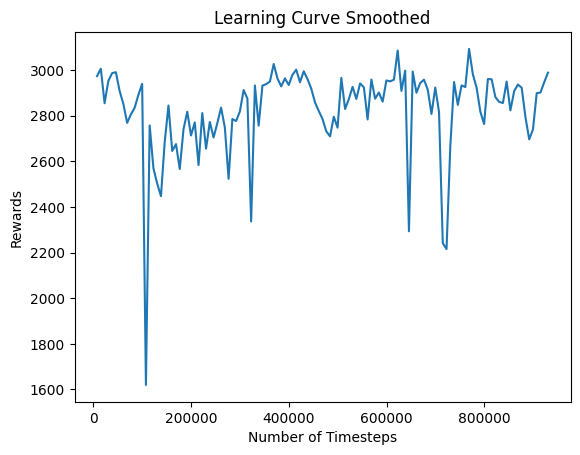

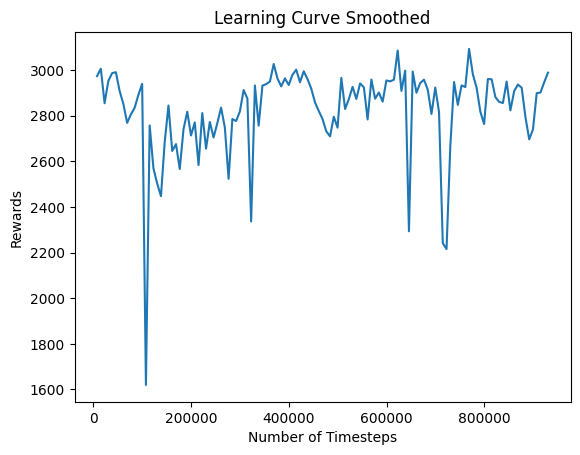

In [ ]:

plot_results(log_dir)

### Eval plots

In [19]:
import matplotlib.pyplot as plt


def plot_socs_and_diff(obsArray, nr_cells):
    fig = plt.figure(1)

    data_np = np.array(obsArray)

    plt.xlabel('Step')
    plt.ylabel('SOC')
    print("------------------------------------------------------")
    plt.ylim([0, 1])

    i = 0
    for soc in data_np.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
        i += 1
    plt.legend()


    fig = plt.figure(1)

    data_diff = []

    i = 0
    minval = 1
    maxval = 0
    for socs in obsArray:
        if minval > min(socs.flatten()):
            minval = min(socs.flatten())

        if maxval < max(socs.flatten()):
            maxval = max(socs.flatten())

    i = 0
    for socs in obsArray:
        diff_group = []
        for soc in socs:
            # diff = ((soc - min(socs.flatten())) * 80)+minval-0.05
            # diff = ((soc - min(socs.flatten())) * 20)+minval-0.15
            diff = ((soc - socs.flatten()[2]) * 20)+minval-0.15
            diff_group.append(diff)
        
        data_diff.append(diff_group)

    data_diff = np.array(data_diff).reshape(-1, nr_cells)

    i = 0
    for soc in data_diff.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="diff"+str(i))
        i += 1


    plt.legend()

    return data_diff


def plot_socs(obsArray):
    fig = plt.figure(3)

    data_np = np.array(obsArray)

    plt.xlabel('Step')
    plt.ylabel('SOC')
    print("------------------------------------------------------")
    plt.ylim([0, 1])

    i = 0
    for soc in data_np.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
        i += 1
    plt.legend()


def plot_diff(obsArray, nr_cells, should_scale):


    fig = plt.figure(4)

    plt.ylim([0.0, 0.3])


    data_np = np.array(obsArray)
    data_diff = []

    i = 0
    for socs in obsArray:
        diff_group = []
        for soc in socs:
            if should_scale:
                diff = (soc - min(socs.flatten()))*10+0.1
            else:
                diff = (soc - socs.flatten()[2])
                plt.ylim([-0.01, 0.02])
            diff_group.append(diff)
        
        data_diff.append(diff_group)

    data_diff = np.array(data_diff).reshape(-1, nr_cells)

    i = 0
    for soc in data_diff.T:
        plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="diff"+str(i))
        i += 1

    plt.legend()

    return data_diff


def plot_diff_section(data_diff, timestep_beginning, timestep_end):
    i = 0
    fig = plt.figure(6)
    plt.ylim([0, 0.02])


    for soc in data_diff.T:
        plt.plot(np.arange(start=timestep_beginning, stop=timestep_end, step=1), soc.flatten()[timestep_beginning:timestep_end], label="diff"+str(i))
        i += 1

### Save trained model

In [8]:
model.save(os.path.join(log_dir, "best_model_td3_new_reward_2step_unlimited_curric_orig"))

# Test 1 episode of the model

In [6]:
from stable_baselines3 import A2C, SAC, PPO, TD3
from stable_baselines3.common.monitor import Monitor
import os



log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)

eval_env = BatteryEnv(cellModel="P14", numCells = 3, simCycles = 10, seed=1, profile = "us06", 
                  balancing="active", getSOCsWhen="all", sampleFactor = 30, utilization=[2, 2], render_mode = False)

eval_env = Monitor(eval_env, log_dir) 

!-- RESTARTED AT :  12:49:56
DONE RESTARTING:  12:49:56
  INITIAL STATE:  [0.9427103 0.942764  0.9427454]  ACTION:[0.9977073 1.0011877 1.001105 ]  SUM:3.0
  STATE +ACTION:  [0.9390081 0.9390878 0.9390263]
  DIFFERENCES  :  [0.0000000e+00 7.9751015e-05 1.8239021e-05]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.9390081 0.9390878 0.9390263]  ACTION:[0.9972322 1.0018834 1.0008844]  SUM:3.0
  STATE +ACTION:  [0.9270692 0.9271808 0.9271014]
  DIFFERENCES  :  [0.0000000e+00 1.1157990e-04 3.2186508e-05]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.9270692 0.9271808 0.9271014]  ACTION:[0.9954821 1.0038732 1.0006447]  SUM:3.0
  STATE +ACTION:  [0.9345142 0.9346552 0.9344998]
  DIFFERENCES  :  [1.4364719e-05 1.5538931e-04 0.0000000e+00]  >>>>    REWARD:  [0.1]   
-----
  INITIAL STATE:  [0.9345142 0.9346552 0.9344998]  ACTION:[0.9965057 1.0030476 1.0004467]  SUM:3.0
  STATE +ACTION:  [0.9251026 0.9252586 0.925083 ]
  DIFFERENCES  :  [1.9609928e-05 1.7565489e-04 0.0000000e+00]  >>

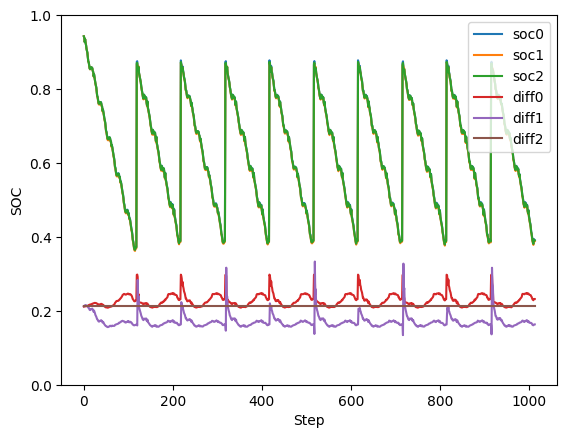

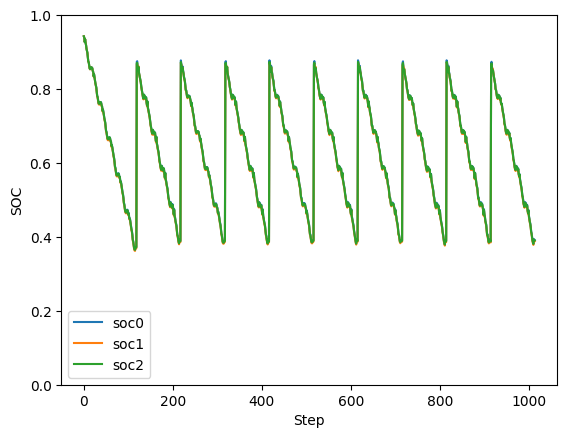

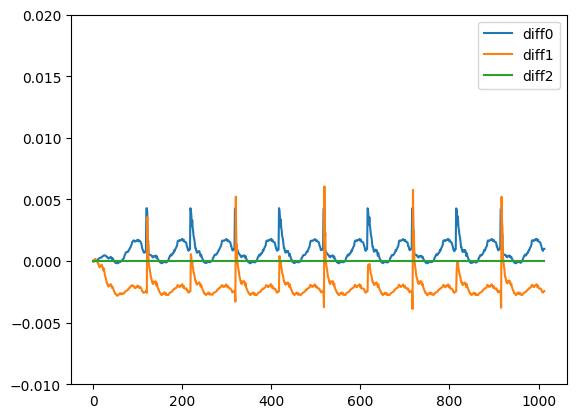

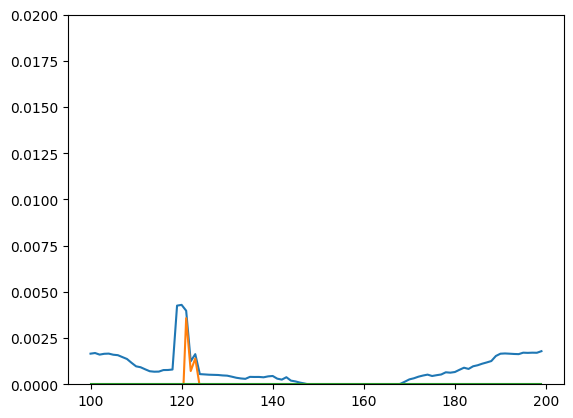

In [20]:




# model = TD3.load(env=eval_env, path=os.path.join(log_dir, "best_model_td3_new_reward_2step_unlimited"))



obs = model.get_env().reset()
episode_reward = 0
obsArray = []
actionArray = []

while True:
    obsArray.append(obs.squeeze())
    action, _states = model.predict(obs)
    actionArray.append(action)
    oldObs = obs
    obs, rewards, done, info = model.get_env().step(action)
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        # for ac in get_converted_action(action.flatten()):
        #     if ac != 0:
        #         print("NON-ZERO!")

        if (np.sum(get_converted_action(action.flatten(), False)) != 3.0):
            print("DEVIATION")
            get_converted_action(action.flatten(), True)
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + np.array2string(get_converted_action(action.flatten(), False)) 
              + "  SUM:" + str(np.sum(get_converted_action(action.flatten(), False))))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        diffs = np.array(diffs)

        print("  DIFFERENCES  :  " + np.array2string(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")


    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(action.flatten(), False)))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences
        data_diff = plot_socs_and_diff(obsArray, nr_cells=env.unwrapped.numCells)
        plot_socs(obsArray=obsArray)
        data_diff = plot_diff(obsArray=obsArray, nr_cells=env.unwrapped.numCells, should_scale=False)
        plot_diff_section(data_diff=data_diff, timestep_beginning=100, timestep_end=200)
        

        break



### Sanity check. See if running the simulation with no action from the model gives us similar results

Values for currents are set to 0 and the simulation runs without intervention. No feedback is applied.

Energy waste graph. ACtive vs passsive
Try lower soc limit to 

!-- RESTARTED AT :  16:33:56
DONE RESTARTING:  16:33:56
  INITIAL STATE:  [0.9427103 0.942764  0.9427454]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.9389988 0.9390926 0.9390308]
  DIFFERENCES  :  [0.0, 9.381771e-05, 3.20673e-05]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.9389988 0.9390926 0.9390308]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.9270259 0.9272084 0.9271168]
  DIFFERENCES  :  [0.0, 0.00018256903, 9.089708e-05]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.9270259 0.9272084 0.9271168]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.934503  0.9346553 0.9345106]
  DIFFERENCES  :  [0.0, 0.00015228987, 7.6293945e-06]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.934503  0.9346553 0.9345106]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.9250571 0.9252884 0.9250982]
  DIFFERENCES  :  [0.0, 0.00023132563, 4.118681e-05]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.9250571 0.9252884 0.9250982]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STA

C:\Users\A493191\AppData\Roaming\Python\Python311\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


  INITIAL STATE:  [0.6230358 0.6258763 0.6239972]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.61653   0.6194164 0.6175285]
  DIFFERENCES  :  [0.0, 0.002886355, 0.000998497]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.61653   0.6194164 0.6175285]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.6108806 0.6138049 0.6119145]
  DIFFERENCES  :  [0.0, 0.002924323, 0.0010338426]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.6108806 0.6138049 0.6119145]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.6009947 0.6039881 0.6020887]
  DIFFERENCES  :  [0.0, 0.0029934049, 0.0010939837]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.6009947 0.6039881 0.6020887]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.5881765 0.5912849 0.5893135]
  DIFFERENCES  :  [0.0, 0.0031083822, 0.0011370182]  >>>>    REWARD:  [1.]   
-----
  INITIAL STATE:  [0.5881765 0.5912849 0.5893135]  ACTION:[[1. 1. 1.]]  SUM:3.0
  STATE +ACTION:  [0.5838785 0.5870289 0.5850211]
  DIFFERENCES  : 

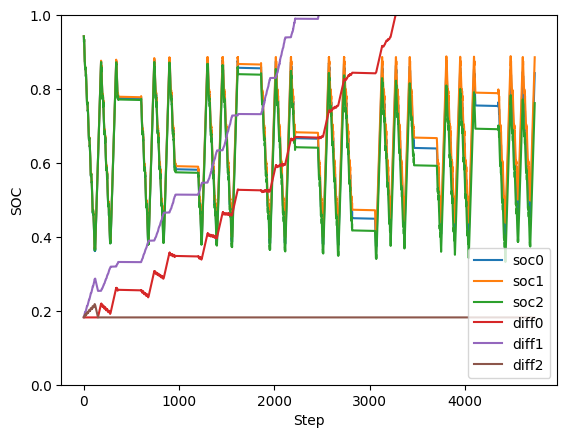

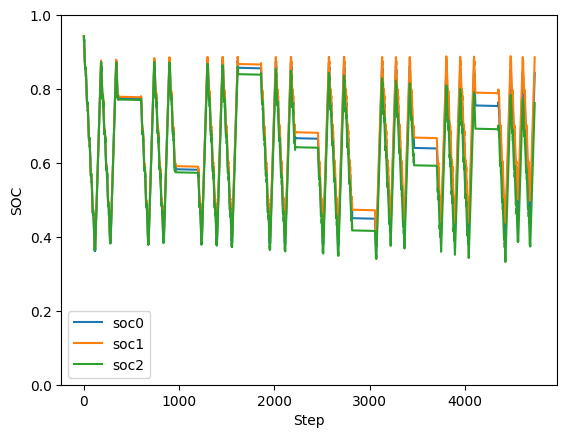

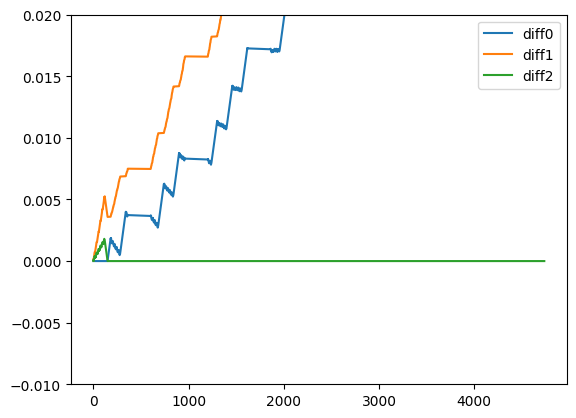

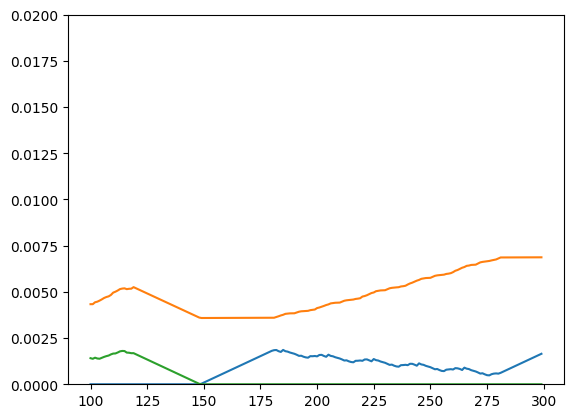

In [8]:
obs = model.get_env().reset()
episode_reward = 0
obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    oldObs = obs
    obs, rewards, done, info = model.get_env().step([[0.0, 0.0, 0.0]])
    action = [[0.0, 0.0, 0.0]]
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        # for ac in get_converted_action(action.flatten()):
        #     if ac != 0:
        #         print("NON-ZERO!")

        if (np.sum(get_converted_action(action, False)) != 3.0):
            print("DEVIATION")
            get_converted_action(action, True)
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + np.array2string(get_converted_action(action, False)) + "  SUM:" + str(np.sum(get_converted_action(action, False))))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        print("  DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")


    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(action)))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences
        data_diff = plot_socs_and_diff(obsArray, nr_cells=env.unwrapped.numCells)
        plot_socs(obsArray=obsArray)
        data_diff = plot_diff(obsArray=obsArray, nr_cells=env.unwrapped.numCells, should_scale=False)
        plot_diff_section(data_diff=data_diff, timestep_beginning=100, timestep_end=300)
        

        break


### Basic non-RL passive balancing - many-cells-per-step discharge

!-- RESTARTED AT :  15:56:51
DONE RESTARTING:  15:56:51
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9427103 0.942764  0.9427454]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9389988 0.9390926 0.9390308]
  DIFFERENCES  :  [0.0, 9.381771e-05, 3.20673e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9389988 0.9390926 0.9390308]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9270259 0.9272084 0.9271168]
  DIFFERENCES  :  [0.0, 0.00018256903, 9.089708e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9270259 0.9272084 0.9271168]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.934503  0.9346553 0.9345106]
  DIFFERENCES  :  [0.0, 0.00015228987, 7.6293945e-06]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.934503  0.9346553 0.9345106]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9250571 0.9252884 0.9250982]
  DIFFERENCES  :  [0.0, 0.00023132563, 4.118681e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9250571 

C:\Users\A493191\AppData\Roaming\Python\Python311\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


[-1.0, 1.0, -1.0]
  INITIAL STATE:  [0.566338  0.5696105 0.5675867]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.5640228 0.5673145 0.5652791]
  DIFFERENCES  :  [0.0, 0.003291726, 0.0012563467]  >>>>    REWARD:  [1.]   
-----
[-1.0, 1.0, -1.0]
  INITIAL STATE:  [0.5640228 0.5673145 0.5652791]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.5636113 0.5669095 0.5648609]
  DIFFERENCES  :  [0.0, 0.0032981634, 0.0012495518]  >>>>    REWARD:  [1.]   
-----
[-1.0, 1.0, -1.0]
  INITIAL STATE:  [0.5636113 0.5669095 0.5648609]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.5684384 0.5717175 0.5696315]
  DIFFERENCES  :  [0.0, 0.0032791495, 0.0011931062]  >>>>    REWARD:  [1.]   
-----
[-1.0, 1.0, -1.0]
  INITIAL STATE:  [0.5684384 0.5717175 0.5696315]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.567229  0.5705242 0.5684139]
  DIFFERENCES  :  [0.0, 0.0032951236, 0.0011848807]  >>>>    REWARD:  [1.]   
-----
[-1.0, 1.0, -1.0]
  INITIAL STATE:  [0.567229  0.5705242 0.5684139]  ACTION:[0.0, 0.0, 0.0]
  STA

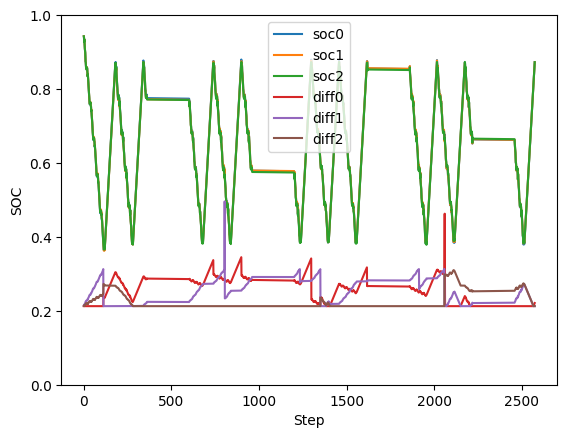

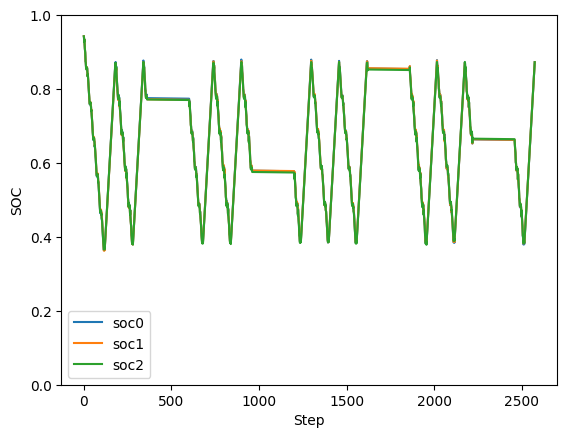

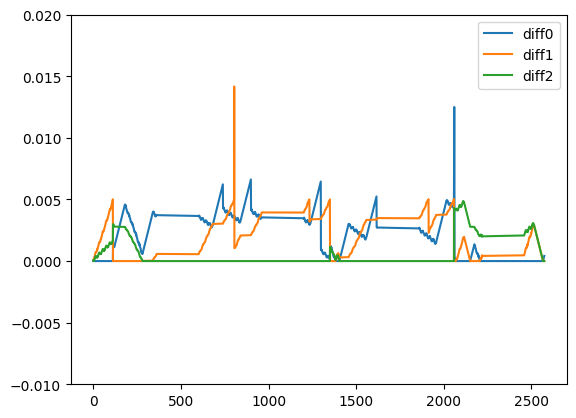

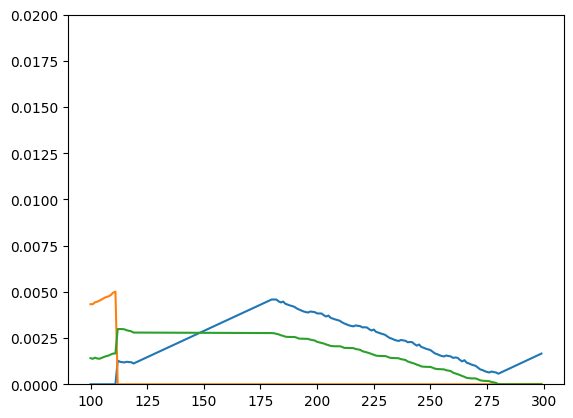

In [12]:
obs = model.get_env().reset()
episode_reward = 0
obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    oldObs = obs

    # Basic passive balancing, non-RL
    # Take the smallest SOC, discharge with fixed rate cells where difference > 0.02
    socs = obs.flatten()
    min_soc = min(socs)
    max_soc = max(socs)
    index_min = np.where(socs == min_soc)[0][0]
    index_max = np.where(socs == max_soc)[0][0]


    diffs = []
    for soc in socs:
        diffs.append(soc - min_soc)
    

    
    # actions = list(itertools.repeat(1, len(action.flatten())))
    actions = [0.0, 0.0, 0.0]
    # for index in range(0, len(socs)):
        # if index != index_min:
    
    
    # 0.1%


    if (max(diffs) > 0.001):
        actions[index_max] = 1.0
        # 1.5

        for index in range(0, len(socs)):
            if index != index_max:
                actions[index] = -1.0
            
                # 0.5

    
    

    print(actions)

    # apply actions
    obs, rewards, done, info = model.get_env().step([actions])
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        # for ac in get_converted_action(action.flatten()):
        #     if ac != 0:
        #         print("NON-ZERO!")
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + str(actions))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        print("  DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")

    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(actions)))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences 
        data_diff = plot_socs_and_diff(obsArray, nr_cells=env.unwrapped.numCells)
        plot_socs(obsArray=obsArray)
        data_diff = plot_diff(obsArray=obsArray, nr_cells=env.unwrapped.numCells, should_scale=False)
        plot_diff_section(data_diff=data_diff, timestep_beginning=100, timestep_end=300)
        break


### Basic non-RL passive balancing - one-cell-per-step discharge

!-- RESTARTED AT :  10:21:41
DONE RESTARTING:  10:21:41
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9427103 0.942764  0.9427454]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9389988 0.9390926 0.9390308]
  DIFFERENCES  :  [0.0, 9.381771e-05, 3.20673e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9389988 0.9390926 0.9390308]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9270259 0.9272084 0.9271168]
  DIFFERENCES  :  [0.0, 0.00018256903, 9.089708e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9270259 0.9272084 0.9271168]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.934503  0.9346553 0.9345106]
  DIFFERENCES  :  [0.0, 0.00015228987, 7.6293945e-06]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.934503  0.9346553 0.9345106]  ACTION:[0.0, 0.0, 0.0]
  STATE +ACTION:  [0.9250571 0.9252884 0.9250982]
  DIFFERENCES  :  [0.0, 0.00023132563, 4.118681e-05]  >>>>    REWARD:  [1.]   
-----
[0.0, 0.0, 0.0]
  INITIAL STATE:  [0.9250571 

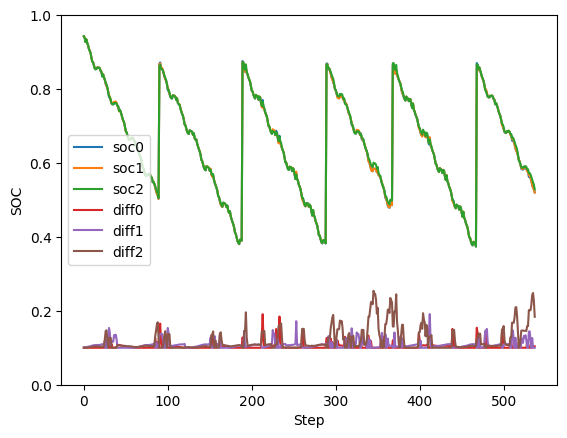

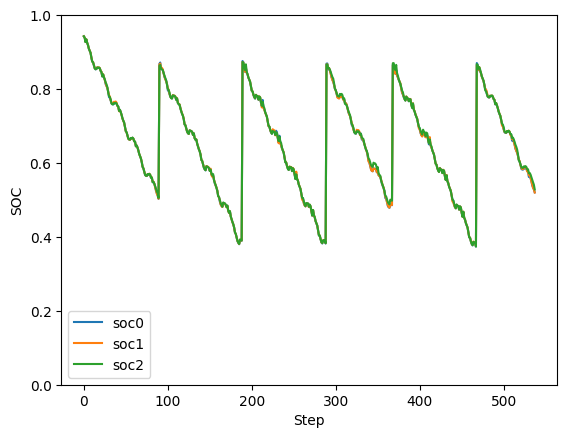

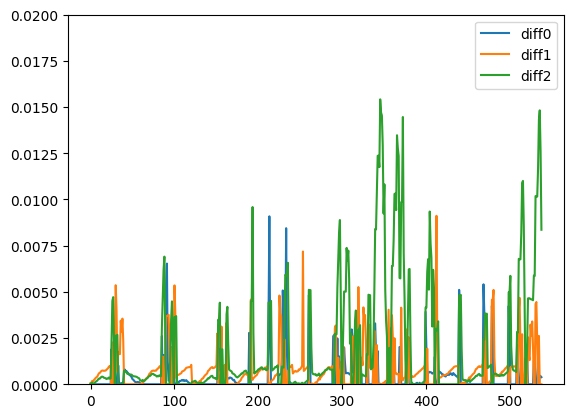

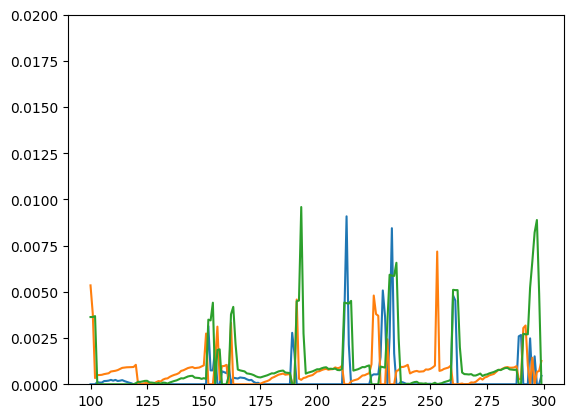

In [103]:
obs = model.get_env().reset()
episode_reward = 0
obsArray = []

while True:
    obsArray.append(obs)
    action, _states = model.predict(obs)
    oldObs = obs

    # Basic passive balancing, non-RL
    # Take the smallest SOC, discharge with fixed rate cells where difference > 0.02
    socs = obs.flatten()
    min_soc = min(socs)
    index_min = np.where(socs == min_soc)[0][0]
    print(index_min)

    diffs = []
    for soc in socs:
        diffs.append(soc - min_soc)
    
    # actions = list(itertools.repeat(1, len(action.flatten())))
    actions = [0.0, 0.0, 0.0]
    for index in range(0, len(socs)):
        if index != index_min:
            if (diffs[index] > 0.001):
                actions[index] = 1.0
                actions[index_min] = -1.0
    
    

    print(actions)

    # apply actions
    obs, rewards, done, info = model.get_env().step([actions])
    episode_reward += rewards.squeeze()

    if not done:
        # Print step
        # for ac in get_converted_action(action.flatten()):
        #     if ac != 0:
        #         print("NON-ZERO!")
        print("  INITIAL STATE:  " +str(oldObs.flatten()) + "  ACTION:" + str(actions))
        print("  STATE +ACTION:  " + str(obs.flatten()) )

        diffs = []
        for o in obs.flatten():
            diffs.append(o - min(obs.flatten()))

        print("  DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("-----")

    else:
        # Print final step
        info_item = info.pop()
        print("FINAL: ")
        print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
        print(str(get_converted_action(actions)))
        diffs = []
        for o in info_item.get('terminal_observation').flatten():
            diffs.append(o - min(info_item.get('terminal_observation').flatten()))

        print("REWARD:  " + str(rewards[0]))
        print("FINAL DIFFERENCES  :  " + str(diffs) + "  >>>>  " + "  REWARD:  "  + str(rewards) + "   ")
        print("EPISODE TOTAL REWARD: " + str(episode_reward))

        # Plot SOCs and differences 
        data_diff = plot_socs_and_diff(obsArray, nr_cells=env.unwrapped.numCells)
        plot_socs(obsArray=obsArray)
        data_diff = plot_diff(obsArray=obsArray, nr_cells=env.unwrapped.numCells, should_scale=False)
        plot_diff_section(data_diff=data_diff, timestep_beginning=100, timestep_end=300)
        break


ValueError: x and y must have same first dimension, but have shapes (900,) and (516,)

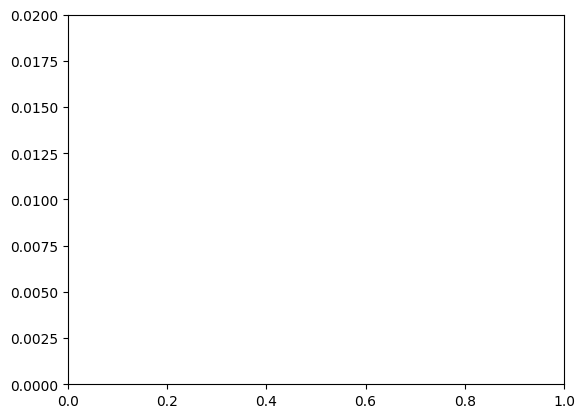

In [31]:
plot_diff_section(data_diff=data_diff, timestep_beginning=100, timestep_end=1000)
